In [1]:
%run setup.py
import tqdm

In [31]:
koi = pd.read_csv('../data/koi_dsct.csv')
toi = pd.read_csv('../data/toi.csv')

from astropy.stats import BoxLeastSquares

def high_pass(t, y, width=3.):
    y_low = gaussian_filter(y, width)
    return y - y_low

def get_kepler_lc(kic_id):
    file = glob.glob(f'../data/lightcurves/Kepler/*{kic_id}.txt')[0]
    t, y = np.loadtxt(file, usecols=(0,1)).T
    return t, y
    
def preprocess_lc(t, y):
    lc = lk.LightCurve(t, y).remove_outliers().remove_nans()
    return lc

def get_tess_lc(ticid):
    try:
        lc = lk.TessLightCurveFile(f'../data/lightcurves/TESS/{ticid}.fits').FLUX
        t, y = lc.time, lc.flux
        print('SC')
        return t, y
    except:
        t, y = np.loadtxt(f'../data/lightcurves/eleanor/{ticid}.csv', usecols=(0,1)).T
        print('LC')
        return t, y


In [32]:
from scipy.optimize import curve_fit

def harmonic_prewhiten(time, flux, frequencies, amplitudes):
    
    def model(time, *theta):
        freq, amp, phi = np.reshape(theta, (3, len(frequencies)))
        return np.sum(amp[:,None] * np.cos((2 * np.pi * freq[:,None] * (time - 0.)) + phi[:,None]), axis=0)
    
    phases = np.ones(len(frequencies))
    x0 = np.array([frequencies, amplitudes, phases]).flatten()
    popt, pcov = curve_fit(model, time, flux - 1., p0=x0)
    leastsq = np.reshape(popt, (3, len(frequencies)))
    covar = np.reshape(np.sqrt(np.diag(pcov)), (3, len(frequencies)))

    return flux - model(time, popt)

## Kepler

In [9]:
from maelstrom.utils import amplitude_spectrum

for index, row in tqdm.tqdm(koi.iterrows(), total=len(koi)):

    t0 =row.koi_time0bk
    p = row.koi_period
    dur = row.koi_duration
    dur_phase = (dur / 24) % p /p
    
    lc = preprocess_lc(*get_kepler_lc(row.kepid))
    
    t, y = lc.time, lc.flux
    pre_f, pre_a = [], []
    fmin = 1
    f,a = amplitude_spectrum(t, y, fmin=fmin, fmax=40)
    noise = 7 * np.median(a[f > fmin])
    f0, a0 = f[np.argmax(a)], np.max(a)
    while a0 > noise:
        pre_f.append(f0)
        pre_a.append(a0)
        y = harmonic_prewhiten(t, y, [f0], [a0])
        f,a = amplitude_spectrum(t, y, fmin=fmin, fmax=40)
        f0, a0 = f[np.nanargmax(a)], np.nanmax(a)
    
    lc_pw = lk.LightCurve(t, y)#.remove_outliers()#.fold(period=p, t0=t0).remove_outliers().plot()

    fig, axes = plt.subplots(2,1,figsize=[5,10])

    ax = axes[0]
    fold = lc_pw.fold(p, t0=t0)
    ax.plot(fold.time, fold.flux, ',k')
    fold.bin(100).plot(ax=ax, lw=2)
    ax.set_xlim(-3*dur_phase, 3*dur_phase)
    ax.set_title(f"{row.kepid}, P={p:.2f}")

    ax =axes[1]
    lc_pw.plot_river(p, t0=t0, ax=ax, cmap='Blues_r')
    ax.set_xlim(-dur_phase*3, 3*dur_phase)
    ax.set_aspect('auto')

    plt.savefig(f"transits/{row.kepoi_name}.png", dpi=300, bbox_inches='tight')
    plt.clf()
    plt.close('all')

100%|██████████| 17/17 [56:03<00:00, 197.87s/it]


## TESS

In [33]:
from maelstrom.utils import amplitude_spectrum

toi = toi[toi['dsct'] == True]

for index, row in tqdm.tqdm(toi[2:].iterrows(), total=len(toi[2:])):

    t0 =row['Epoch (BJD)']
    p = row['Period (days)']
    dur = row['Duration (hours)']
    dur_phase = (dur / 24) % p /p
    
    lc = preprocess_lc(*get_tess_lc(row['TIC ID']))
    
    t, y = lc.time, lc.flux
#     t += 2457000
#     pre_f, pre_a = [], []
#     fmin = 5
#     f,a = amplitude_spectrum(t, y, fmin=fmin, fmax=40)
#     noise = 7 * np.median(a[f > fmin])
#     f0, a0 = f[np.argmax(a)], np.max(a)
#     while a0 > noise:
#         pre_f.append(f0)
#         pre_a.append(a0)
#         y = harmonic_prewhiten(t, y, [f0], [a0])
#         f,a = amplitude_spectrum(t, y, fmin=fmin, fmax=40)
#         f0, a0 = f[np.nanargmax(a)], np.nanmax(a)
    
    lc_pw = lk.LightCurve(t, y).remove_outliers()#.fold(period=p, t0=t0).remove_outliers().plot()

    fig, axes = plt.subplots(2,1,figsize=[5,10])

    ax = axes[0]
    fold = lc_pw.fold(p, t0=t0)
    ax.plot(fold.time, fold.flux, ',k')
    fold.bin(100).plot(ax=ax, lw=2)
    ax.set_xlim(-3*dur_phase, 3*dur_phase)
    ax.set_title(f"{row.TOI}, P={p:.2f}")

    ax =axes[1]
    lc_pw.plot_river(p, t0=t0, ax=ax, cmap='Blues_r')
    ax.set_xlim(-dur_phase*3, 3*dur_phase)
    ax.set_aspect('auto')

    plt.savefig(f"transits/TOI-{row.TOI}.png", dpi=300, bbox_inches='tight')
    plt.clf()
    plt.close('all')





  0%|          | 0/11 [00:00<?, ?it/s]

SC






  9%|▉         | 1/11 [00:01<00:18,  1.81s/it]

SC






 18%|█▊        | 2/11 [00:03<00:16,  1.83s/it]

SC






 27%|██▋       | 3/11 [00:06<00:17,  2.19s/it]

LC






 36%|███▋      | 4/11 [00:08<00:13,  1.97s/it]

LC






 45%|████▌     | 5/11 [00:10<00:11,  1.94s/it]

LC






 55%|█████▍    | 6/11 [00:11<00:09,  1.84s/it]

LC






 64%|██████▎   | 7/11 [00:13<00:06,  1.69s/it]

LC






 73%|███████▎  | 8/11 [00:14<00:04,  1.63s/it]

SC






 82%|████████▏ | 9/11 [00:16<00:03,  1.82s/it]

LC






 91%|█████████ | 10/11 [00:18<00:01,  1.75s/it]

LC






100%|██████████| 11/11 [00:20<00:00,  1.85s/it]


In [25]:
t, y = lc.time, lc.flux

f,a = amplitude_spectrum(t, y, fmin=fmin, fmax=40)
noise = 7 * np.median(a[f > fmin])
f0, a0 = f[np.argmax(a)], np.max(a)
f0

11.947486556838367

In [6]:

row = koi[koi['kepid']== 6116172].iloc[0]

t0 =row.koi_time0bk
p = row.koi_period
dur = row.koi_duration
dur_phase = (dur / 24) % p /p

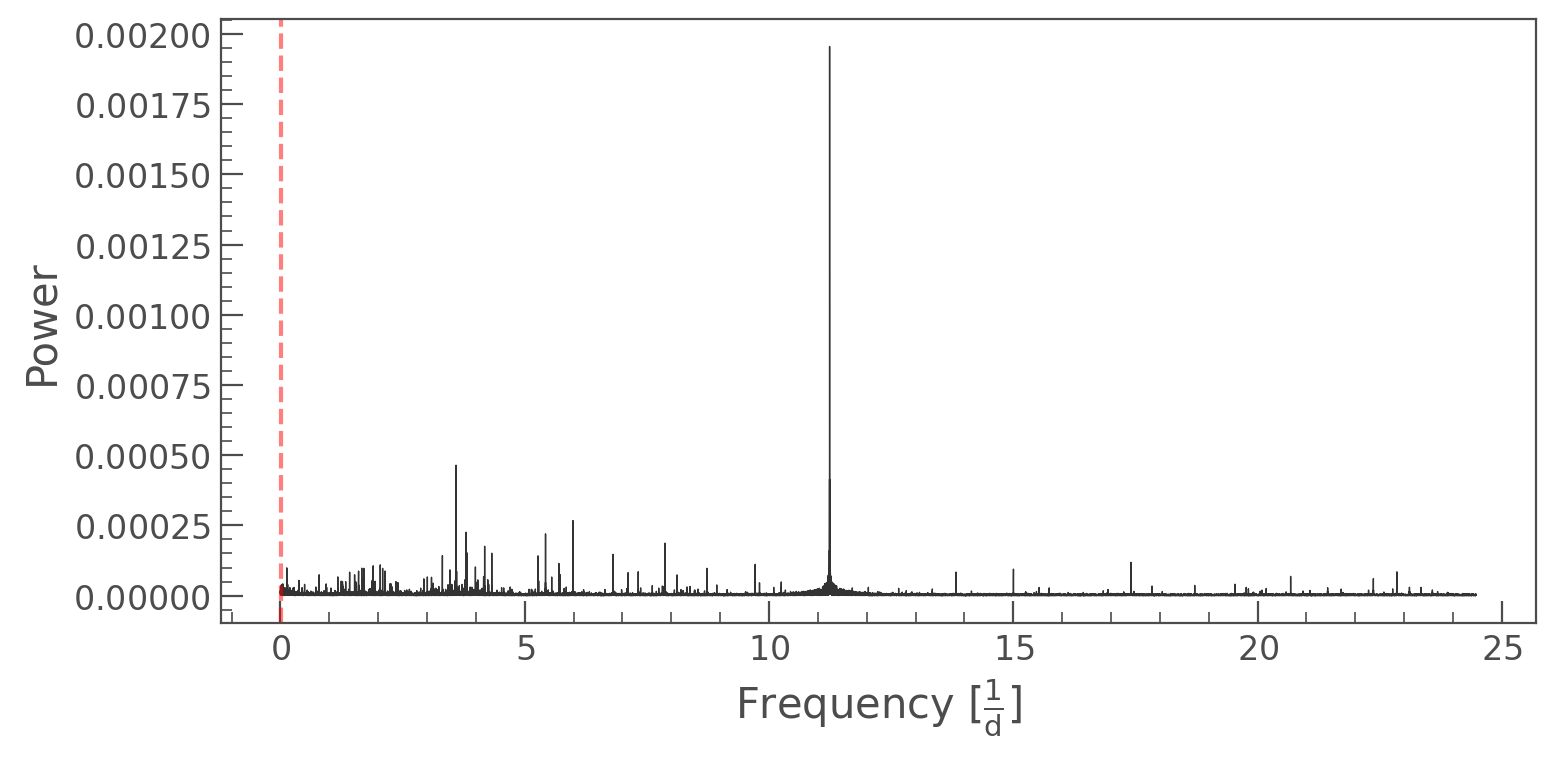

In [48]:
# data = lk.search_lightcurvefile(f"KIC {row.kepid}").download_all()
lc = preprocess_lc(*get_kepler_lc(row.kepid))
ax = lc.to_periodogram().plot()
ax.axvline(1/row.koi_period, c='r', linestyle='dashed', alpha=0.5)

In [49]:
from maelstrom.utils import amplitude_spectrum
# lc = data.PDCSAP_FLUX.stitch().remove_nans()
t, y = lc.time, lc.flux
pre_f, pre_a = [], []
fmin = 1
f,a = amplitude_spectrum(t, y, fmin=fmin, fmax=40)
noise = 7 * np.median(a[f > fmin])
f0, a0 = f[np.argmax(a)], np.max(a)
while a0 > noise:
    pre_f.append(f0)
    pre_a.append(a0)
    y = harmonic_prewhiten(t, y, [f0], [a0])
    f,a = amplitude_spectrum(t, y, fmin=fmin, fmax=40)
    f0, a0 = f[np.nanargmax(a)], np.nanmax(a)

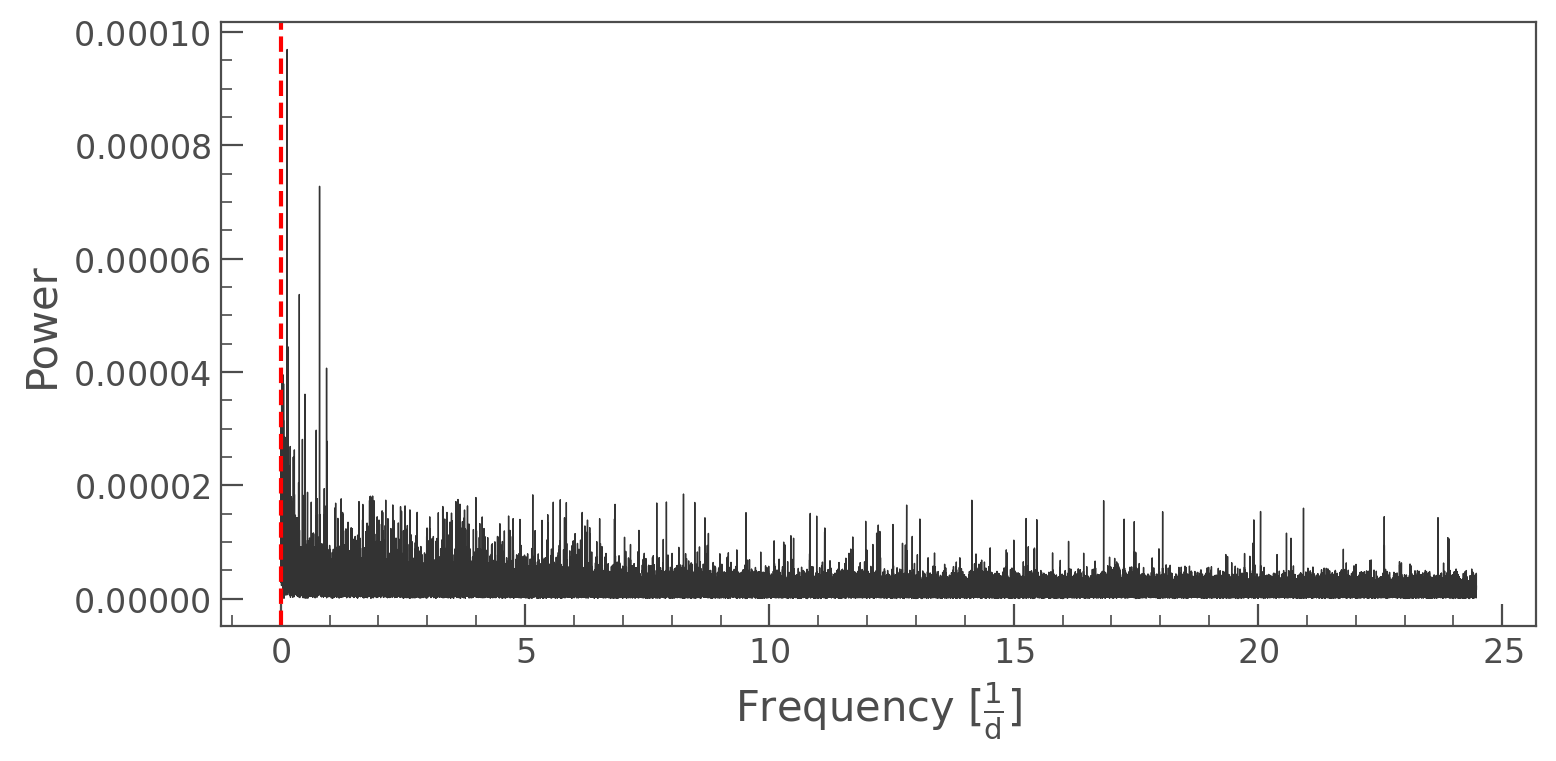

In [64]:
lc_pw = lk.LightCurve(t, y).remove_outliers()#.fold(period=p, t0=t0).remove_outliers().plot()
ax = lc_pw.to_periodogram().plot()
ax.axvline(1/row.koi_period, c='r', linestyle='dashed')

AttributeError: 'QuadMesh' object has no property 'bins'

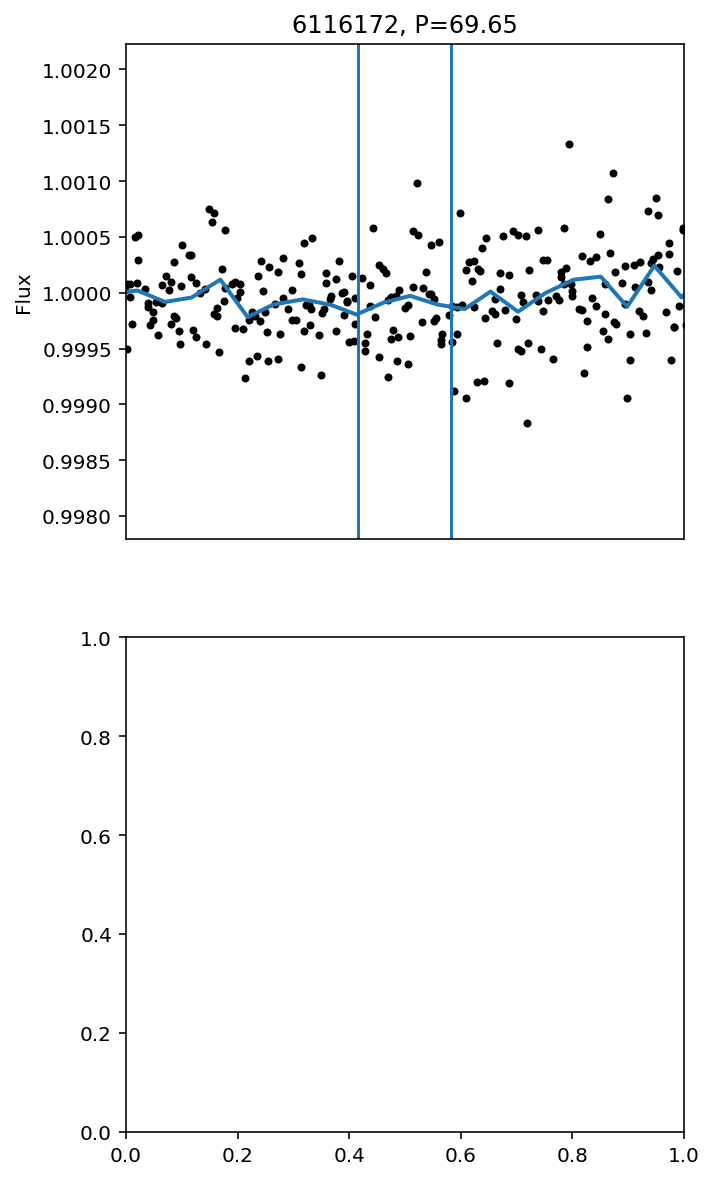

In [68]:
# lc_pw = lk.LightCurve(t, y).remove_outliers()#.fold(period=p, t0=t0).remove_outliers().plot()
fig, axes = plt.subplots(2,1,figsize=[5,10])

ax = axes[0]
fold = lc_pw.fold(p, t0=t0)
ax.plot(fold.time, fold.flux, '.k')
fold.bin().plot(ax=ax, lw=2)
# ax.set_xlim(-(dur / p)*2, (dur / p)*2)
ax.set_xlim(-3*dur_phase, 3*dur_phase)
ax.set_title(f"{row.kepid}, P={p:.2f}")
ax.set_xticks([])
ax.set_xlabel('')
ax.axvline(0-dur_phase/2)
ax.axvline(0+dur_phase/2)

ax =axes[1]
lc_pw.plot_river(p, t0=t0, ax=ax, cmap='Blues')

# cb = ax.collections[-1].colorbar 
# Do any actions on the colorbar object (e.g. remove it)
# cb.remove()

ax.set_xlim(-3*dur_phase, 3*dur_phase)
ax.set_aspect('auto')

plt.subplots_adjust(hspace=0.05)
# plt.savefig(f"transits/{row.kepid}_{p}.png", dpi=300, bbox_inches='tight')

In [72]:
# plt.style.use('science')

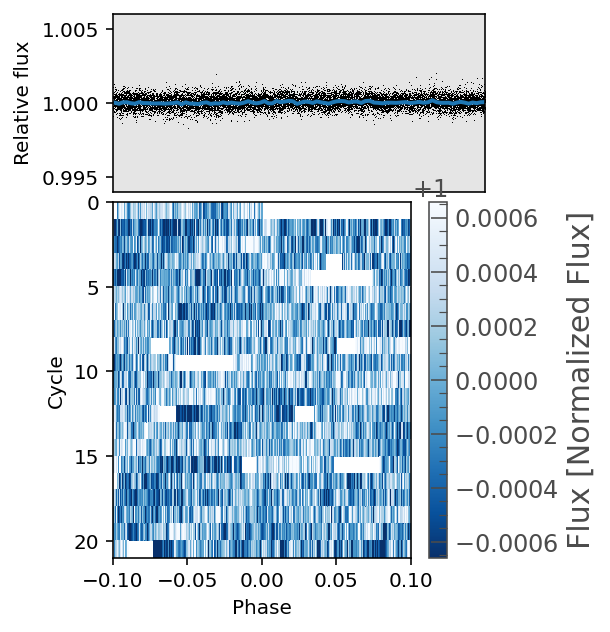

In [47]:

# lc_pw = lk.LightCurve(t, y).remove_outliers()#.fold(period=p, t0=t0).remove_outliers().plot()
fig, axes = plt.subplots(2,1,figsize=[3.3333, 5], gridspec_kw={'height_ratios':[0.5, 1]})

ax = axes[0]
fold = lc_pw.fold(p, t0=t0)
ax.plot(fold.time, fold.flux, ',k', alpha=1, rasterized=True)
binned = fold.bin(150)
ax.plot(binned.time, binned.flux, c="C0", lw=2, rasterized=True)
# ax.set_xlim(-(dur / p)*2, (dur / p)*2)
ax.set_xlim(-0.1, 0.1)
# ax.set_title(f"{row.kepid}, P={p:.2f}")
ax.set_xticks([])
ax.set_xlabel('')
ax.set_ylim(0.994, 1.006)
ax.set_yticks([0.995, 1., 1.005])
ax.set_ylabel("Relative flux")
ax.axvspan(-dur/2, dur/2, color='grey', alpha=0.2)

ax =axes[1]
lc_pw.plot_river(p, t0=t0, ax=ax, cmap='Blues_r')
ax.set_xlim(-0.1, 0.1)
ax.set_aspect('auto')

# plt.axvspan(-dur/2, dur/2, color='grey', alpha=0.2)
plt.subplots_adjust(hspace=0.04)
# plt.savefig(f"transits/{row.kepid}_{p}.png", dpi=300, bbox_inches='tight')

# plt.savefig(overleaf_path + "6116172_notransit.pdf")

In [12]:
x, y, e = lc_pw.time, lc_pw.flux, lc_pw.flux_err
period = row.koi_period
s = np.argsort(x)
x, y, e = x[s], y[s], e[s]
med = np.nanmedian(y)
e /= med
y /= med

bin_points=1
minimum_phase=-0.5
maximum_phase=0.5
n = int(period/np.nanmedian(np.diff(x)) * (maximum_phase - minimum_phase)/bin_points)

ph = x/period % 1
cyc = np.asarray((x - x % period)/period, int)
cyc -= np.min(cyc)

phase = (t0 % period) / period
ph = ((x - (phase * period)) / period) % 1
cyc = np.asarray((x - ((x - phase * period) % period))/period, int)
cyc -= np.min(cyc)
ph[ph > 0.5] -= 1

ar = np.empty((n, np.max(cyc) + 1))
ar[:] = np.nan
bs = np.linspace(minimum_phase, maximum_phase, n)
cycs = np.arange(0, np.max(cyc) + 1)

ph_masks = [(ph > bs[jdx]) & (ph <= bs[jdx+1]) for jdx in range(n-1)]
qual_mask = np.isfinite(y)
bin_func = lambda y, e: (y[0], e[0])
for cyc1 in np.unique(cyc):
    cyc_mask = cyc == cyc1
    if not np.any(cyc_mask):
        continue
    for jdx, ph_mask in enumerate(ph_masks):
        if not np.any(cyc_mask & ph_mask & qual_mask):
            ar[jdx, cyc1] = np.nan
        else:
            ar[jdx, cyc1] = bin_func(y[cyc_mask & ph_mask],
                                             e[cyc_mask & ph_mask])[0]

In [13]:
plt.style.use('science')

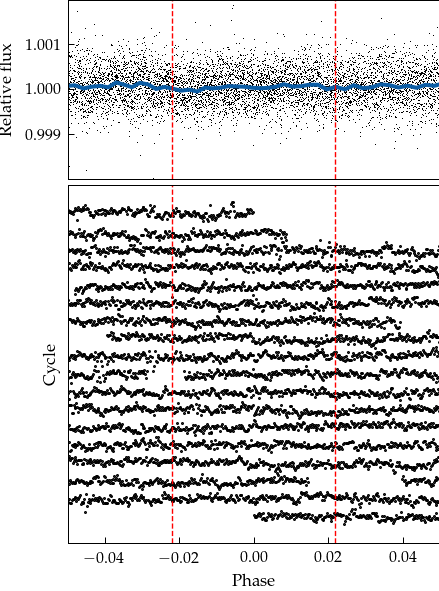

In [14]:
import seaborn as sns

# lc_pw = lk.LightCurve(t, y).remove_outliers()#.fold(period=p, t0=t0).remove_outliers().plot()
fig, axes = plt.subplots(2,1,figsize=[3.3333, 5], gridspec_kw={'height_ratios':[0.5, 1]})

ax = axes[0]
fold = lc_pw.fold(p, t0=t0)
ax.plot(fold.time, fold.flux, ',k', alpha=1, rasterized=True)
binned = fold.bin(150)
ax.plot(binned.time, binned.flux, c="C0", lw=2, rasterized=True)
# ax.set_xlim(-(dur / p)*2, (dur / p)*2)
ax.set_xlim(-0.05, 0.05)

# ax.set_title(f"{row.kepid}, P={p:.2f}")
ax.set_xticks([])
ax.set_xlabel('')
ax.set_ylim(0.998, 1.002)
ax.set_yticks([0.999, 1., 1.001])
ax.set_ylabel("Relative flux")
# ax.axvspan(-dur/2, dur/2, color='grey', alpha=0.2)
ax.axvline(-dur/2, c='red', linestyle='--', lw=0.7)
ax.axvline(dur/2, c='red', linestyle='--', lw=0.7)

cc = sns.color_palette(palette='viridis', n_colors=len(ar.T))

ax = axes[1]
for i, a in enumerate(ar.T):
    ax.plot(bs, a - 0.0025*i, '.k',ms=1.,lw=0.9, 
#             c=cc[i]);
           )
    
ax.set_xlim(-0.05, 0.05)

ax.axvline(-dur/2, c='red', linestyle='--', lw=0.7)
ax.axvline(dur/2, c='red', linestyle='--', lw=0.7)

ax.set_yticks([])
ax.set_ylabel('Cycle')
ax.set_xlabel('Phase')
plt.subplots_adjust(hspace=0.025)
# plt.axvspan(-dur/2, dur/2, color='grey', alpha=0.1)

# plt.savefig(overleaf_path + "6116172_notransit.pdf")

0.043791666666666666

In [ ]:
r

In [ ]:
# from maelstrom.utils import amplitude_spectrum
# # lc = data.PDCSAP_FLUX.stitch().remove_nans()
# t, y = lc.time, lc.flux

# forb = (1/row.koi_period)
# fmax = 40
# f,a = amplitude_spectrum(t, y, fmax=fmax)
# m = (f < (forb + 0.1)) & (f > (forb - 0.1))
# m = ~m

# noise = 7 * np.median(a[m])
# f0, a0 = f[m][np.argmax(a[m])], np.max(a[m])
# # plt.plot(f[m],a[m])
# while a0 > noise:
#     y = harmonic_prewhiten(t, y, [f0], [a0])
#     f,a = amplitude_spectrum(t, y, fmax=fmax)
#     f0, a0 = f[m][np.nanargmax(a[m])], np.nanmax(a[m])
# #     print(f0, a0)